# 📊 **RAGAS – Valutazione Pipeline RAG con Metriche Standard**

## 🧪 Creazione del Dataset di Valutazione

### 🔹 Metodo 1: Dataset Generato con AI (testset)

* Creato da RAGAS a partire dai documenti (`generate_with_langchain_docs`)
* 🔁 Richiede molte chiamate OpenAI

### 🔹 Metodo 2: Dataset Manuale (raccomandato ✅)

* File `qa.csv` con colonne:

  * `question`
  * `ground_truth`

```python
import pandas as pd

df = pd.read_csv("qa.csv")
questions = df["question"].tolist()
ground_truths = df["ground_truth"].tolist()
```

In [1]:
from langchain_community.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
load_dotenv()
import os

openai_api_key = os.getenv("OPENAI_API_KEY")


loader = DirectoryLoader("./data", glob="**/*.txt")

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=350,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False
)

chunks = text_splitter.split_documents(docs)

libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.
libmagic is unavailable but assists in filetype detection. Please consider installing libmagic for better results.


---

## 🧱 Pipeline RAG (base)

In [6]:
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI

embedding = OpenAIEmbeddings()

model = ChatOpenAI(model="gpt-4o-mini")

vectorstore = Chroma.from_documents(chunks, embedding)

retriever = vectorstore.as_retriever()

In [4]:
from langchain_core.prompts import PromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = PromptTemplate(template=template, input_variable=["context", "question"])

In [7]:
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

---

## 📦 Costruzione del Dataset finale per RAGAS

In [9]:
import pandas as pd

df = pd.read_csv("./questions_answers/qa.csv", delimiter=";")

print(df.head())

                                            question  \
0                              Where was Amico born?   
1         What was Amico's early culinary influence?   
2  What skill did Amico learn from Palermo's mark...   
3  Where in Italy did Amico gain culinary experie...   
4         What is "Chef Amico" restaurant known for?   

                                        ground_truth  
0  Amico was born in the heart of the old quarter...  
1  Amico was influenced by the cooking in his Non...  
2  Amico learned to select the freshest fish and ...  
3  Amico gained culinary experience across variou...  
4  Chef Amico is known for combining Sicilian and...  


In [12]:
questions = df['question'].tolist()
ground_truth = df["ground_truth"].tolist()

In [13]:
ground_truth

['Amico was born in the heart of the old quarter of Palermo.',
 "Amico was influenced by the cooking in his Nonna Lucia's kitchen.",
 "Amico learned to select the freshest fish and ripest fruits from Palermo's markets.",
 'Amico gained culinary experience across various regions in Italy, including Tuscany and Venice.',
 'Chef Amico is known for combining Sicilian and modern Italian cuisine.',
 "The menu reflects Amico's culinary journey and commitment to excellence.",
 "Amico sees hospitality as an art of celebrating life's simple pleasures.",
 "Chef Amico is distinguished by Amico's dedication and the community he nurtures.",
 'Amico mentors young chefs, conducts culinary workshops, and supports local producers.',
 "Amico's legacy lies in his community involvement and passion for food.",
 'Chef Amico is set in a quaint alley in Palermo.',
 'Chef Amico has a welcoming atmosphere with aromatic garlic and olive oil.',
 "The walls showcase Amico's travels and family recipes, representing 

In [15]:
from datasets import Dataset

data = {"question": [], "answer": [], "contexts": [], "ground_truth": ground_truth}

for query in questions:
    data['question'].append(query)
    data['answer'].append(rag_chain.invoke(query))
    data['contexts'].append(
        [doc.page_content for doc in retriever.invoke(query)]
    )

dataset = Dataset.from_dict(data)

In [16]:
first_entry = {
    "question": data['question'][0],
    "answer": data['answer'][0], 
    "contexts": data["contexts"][0],
    "ground_truth": data["ground_truth"][0]
}
first_entry

{'question': 'Where was Amico born?',
 'answer': 'The context provided does not specify where Amico was born.',
 'contexts': ['From a young age, Amico was immersed in the art of Sicilian cooking. His days were punctuated by visits to the bustling markets of Palermo, where he learned to choose the freshest fish from the Mediterranean and the ripest fruits kissed by the Sicilian sun. These experiences not only sharpened his culinary skills but also deepened his respect for',
  'From a young age, Amico was immersed in the art of Sicilian cooking. His days were punctuated by visits to the bustling markets of Palermo, where he learned to choose the freshest fish from the Mediterranean and the ripest fruits kissed by the Sicilian sun. These experiences not only sharpened his culinary skills but also deepened his respect for',
  'From a young age, Amico was immersed in the art of Sicilian cooking. His days were punctuated by visits to the bustling markets of Palermo, where he learned to choos

Come vediamo la prima risposta generata dal modello in answer non va bene. 

Vogliamo utilizzare metriche standard per valutare le nostre prestazioni.

Dopo aver apportato alcune modifiche, ad esempio usiamo un modello ed un retriever migliore come vedremo più avanti.

---

## 📏 Valutazione con RAGAS


Importiamo la funzione `evaluate` ragas. Importiamo anche dal modulo ragas delle metriche come: Faithfulness, answer_relevancy, context_relevancy, context_recall, context_precision


## 🔍 Perché `evaluate()` richiede `llm` e `embeddings`?

La funzione `ragas.evaluate()` calcola diverse **metriche semantiche** tra:

* la **query** (`question`),
* la **risposta** (`answer`),
* i **contesti** (`contexts`),
* e la **verità di riferimento** (`ground_truth`),

e per farlo ha bisogno di **comprendere** il significato dei testi. Per questo si appoggia a:

* 🔠 **un LLM (`llm`)**: per eseguire confronti generativi o scoring testuale (es. *faithfulness*),
* 🧠 **un embedding model (`embeddings`)**: per confronti vettoriali e metriche di similarità (es. *context recall*, *context precision*).

---

## 🧠 Ruolo di ciascuno:

### ✅ `llm=...` (es. `ChatOpenAI()`)

Serve per valutare **coerenza semantica e factual correctness**:

| Metrica               | Usa `llm`? | Come lo usa                                                       |
| --------------------- | ---------- | ----------------------------------------------------------------- |
| **Faithfulness**      | ✅ sì       | LLM valuta se la risposta è supportata dal contesto               |
| **Answer Relevancy**  | ✅ sì       | LLM valuta se la risposta è effettivamente centrata sulla domanda |
| **Context Relevancy** | ✅ sì       | LLM valuta se ogni chunk è utile per rispondere alla domanda      |

---

### ✅ `embeddings=...` (es. `OpenAIEmbeddings()`)

Serve per confrontare **vettorialmente** i contenuti (query ↔ context ↔ ground\_truth):

| Metrica               | Usa `embeddings`? | Come lo usa                                           |
| --------------------- | ----------------- | ----------------------------------------------------- |
| **Context Recall**    | ✅ sì              | Misura quanto il ground truth è coperto dai context   |
| **Context Precision** | ✅ sì              | Misura quanto i context sono pertinenti alla risposta |

> 📌 Entrambe si basano su **cosine similarity** tra vettori generati dai testi.


## 🧾 In sintesi

| Parametro    | Obbligatorio? | Serve per...                                |
| ------------ | ------------- | ------------------------------------------- |
| `llm`        | ✅ sì          | Valutazioni qualitative e semantiche        |
| `embeddings` | ✅ sì          | Valutazioni basate su similarità vettoriale |

Senza questi due, **RAGAS non può eseguire correttamente le metriche**, perché non ha modo di "capire" i testi.

In [19]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness, 
    answer_relevancy,
    context_recall, 
    context_precision
)

result = evaluate(
    dataset=dataset,
    metrics=[
        context_precision, 
        context_recall, 
        faithfulness, 
        answer_relevancy
    ],
    llm=model,
    embeddings=embedding
)

Evaluating: 100%|██████████| 120/120 [00:48<00:00,  2.46it/s]


## 📊 Visualizzazione Risultati

### DataFrame Pandas

In [20]:
result.to_pandas()

,user_input,retrieved_contexts,response,reference,context_precision,context_recall,faithfulness,answer_relevancy
0,Where was Amico born?,"[From a young age, Amico was immersed in the a...",The context provided does not specify where Am...,Amico was born in the heart of the old quarter...,0.00,0.0,1.000000,0.000000
1,What was Amico's early culinary influence?,"[From a young age, Amico was immersed in the a...",Amico's early culinary influence was the art o...,Amico was influenced by the cooking in his Non...,0.25,0.0,0.833333,0.994577
2,What skill did Amico learn from Palermo's mark...,"[From a young age, Amico was immersed in the a...",Amico learned to choose the freshest fish from...,Amico learned to select the freshest fish and ...,1.00,1.0,1.000000,0.947689
3,Where in Italy did Amico gain culinary experie...,"[As he grew, so did his desire to explore beyo...",Amico gained culinary experience in various re...,Amico gained culinary experience across variou...,1.00,1.0,1.000000,0.974451
4,"What is ""Chef Amico"" restaurant known for?","[Creating Chef Amico’s Restaurant, Creating Ch...","Chef Amico's restaurant is known for its menu,...",Chef Amico is known for combining Sicilian and...,0.25,1.0,0.857143,0.992861
5,What does Amico's restaurant menu reflect?,"[At Chef Amico, every dish told a story. The m...",Amico's restaurant menu reflects his journey a...,The menu reflects Amico's culinary journey and...,1.00,1.0,1.000000,1.000000
6,How does Amico perceive hospitality?,"[For Amico, hospitality was an art form. He be...",Amico perceives hospitality as an art form. He...,Amico sees hospitality as an art of celebratin...,1.00,1.0,1.000000,1.000000
7,"What distinguishes ""Chef Amico"" in Palermo?","[Returning to Palermo with a vision, Amico ope...","""Chef Amico"" is distinguished by its authentic...",Chef Amico is distinguished by Amico's dedicat...,0.25,0.0,0.555556,0.968408
8,What activities does Amico engage in besides c...,"[From a young age, Amico was immersed in the a...",The context provided does not specifically men...,"Amico mentors young chefs, conducts culinary w...",0.00,0.0,0.750000,0.000000
9,How is Amico's legacy beyond his dishes?,[Amico’s legacy is not just in the dishes he c...,Amico's legacy extends beyond his dishes throu...,Amico's legacy lies in his community involveme...,1.00,1.0,1.000000,0.957099


### Mappa di Calore (con seaborn)

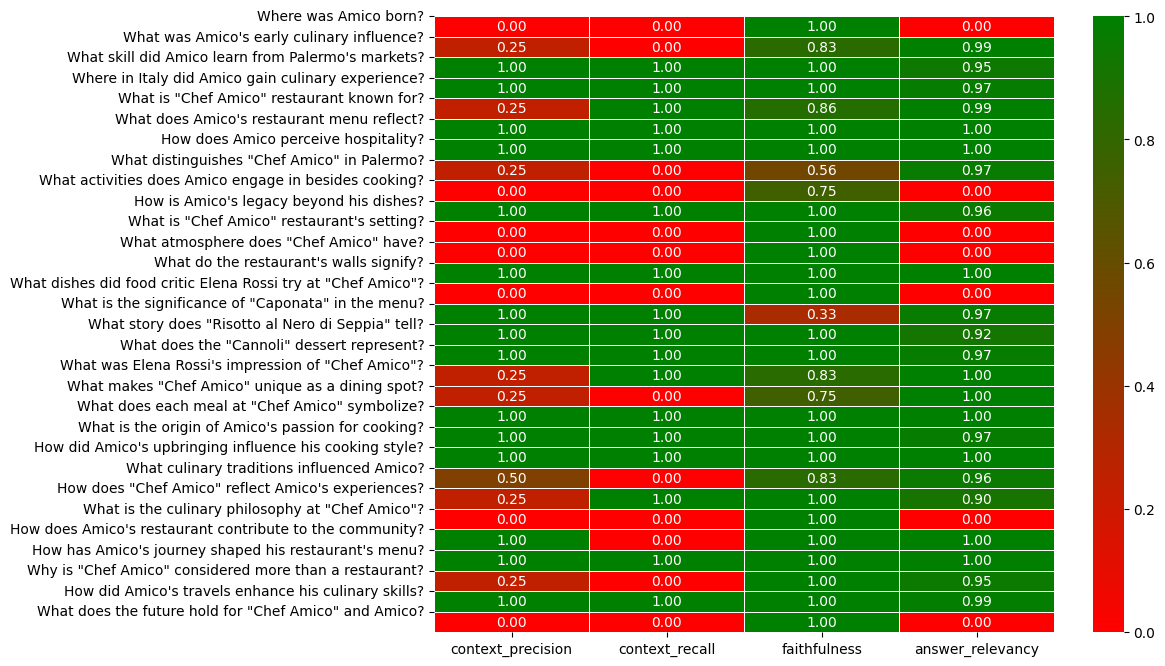

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

df = result.to_pandas()

# prendiamo le colonne delle metriche dal df
heatmap_data = df[
    [
        "context_precision", 
        "context_recall", 
        "faithfulness",
        "answer_relevancy"
    ]
]

# Crea una mappa di colori continua che va da rosso (0) a verde (1).
cmap = LinearSegmentedColormap.from_list("green_red", ["red", "green"])

plt.figure(figsize=(10, 8))

#🔥 Crea la heatmap:

# heatmap_data: matrice dei valori (righe=domande, colonne=metriche),

# annot=True: mostra il valore numerico dentro ogni cella,

# fmt=".2f": formatta i numeri con 2 decimali,

# linewidths=0.5: separazione visiva tra celle,

# cmap=cmap: usa la colormap rosso-verde.


sns.heatmap(heatmap_data, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap)

# 📝 Imposta le etichette dell’asse Y:

# ogni riga mostra la domanda corrispondente (df['user_input']),

# rotation=0: le scritte sono orizzontali, leggibili.

plt.yticks(ticks=range(len(df['user_input'])), labels=df['user_input'], rotation=0)

# mostra la heatmap a schermo
plt.show()

---

## 📉 Risultato: Valutazione di Base

| Metrica              | Valore tipico iniziale   |
| -------------------- | ------------------------ |
| Faithfulness         | ✅ Medio-alto             |
| Answer Relevancy     | ✅ Medio                  |
| Context Precision    | ❌ Basso                  |
| Context Recall       | ❌ Basso                  |

---

## 🔄 Interpretazione

👉 Le metriche sono basse perché:

* Pipeline RAG **molto semplice**
* Chunking non ottimale
* Embedding base (OpenAI)
* Nessun reranking o rewriting
* LLM = `gpt-4o-mini`

📌 Ma questo serve da **baseline** su cui applicare miglioramenti.

---

## ✅ Best Practice

| Cosa fare                                     | Perché                     |
| --------------------------------------------- | -------------------------- |
| Valutare con RAGAS prima e dopo ogni modifica | Misura l’impatto reale     |
| Usare testset manuali                         | Conosci meglio i tuoi dati |
| Visualizzare risultati con Pandas/Seaborn     | Facilita l’analisi         |

---

## 🔜 Prossimo Step

➡️ Miglioramento della pipeline RAG:

* ✅ Chunking intelligente
* ✅ Prompt migliori
* ✅ Cross-encoder reranker
* ✅ Query rewriting
* ✅ Embedding avanzati (es. `bge-large`, `jina-v4`, `nomic`)